# Classificiation of single and double events
This notebook aims to build a model capable of classifying single and double events in a mixed dataset.

In [1]:
"""
Here are the data files.  For all data files each image and label is on one row.  
The first 256 values in each row correspond to the 16x16 detector image and 
the last 6 values correspond to Energy1, Xpos1, Ypos1, Energy2, Xpos2, Ypos2.  
If there is no second particle then Energy2 = 0 and Xpos2 and Ypos2 are both -100.  
(When I run my model, I have to reset the -100 to 0).
 
CeBr10kSingle are 10,000 rows of data and labels for single interactions in the detector
CeBr10k_1.txt is 10,000 rows of data and labels with a mix of single interactions and double interactions
CeBr10.txt is a small file I use which contains 10 single interactions.
"""

import numpy as np
import matplotlib.pyplot as plt
from data_functions import separate_simulated_data, label_simulated_data

# File import
PATH = "../data/small_sample/"
filenames = ["CeBr10kSingle_1.txt", "CeBr10kSingle_2.txt", "CeBr10k_1.txt", "CeBr10.txt"]

## single, mix, small define which dataset to load.
file_to_load = "mix"

if file_to_load == "single_1":
    infile = PATH+filenames[0]
if file_to_load == "single_2":
    infile = PATH+filenames[1]
if file_to_load == "mix":
    infile = PATH+filenames[2]
if file_to_load == "small":
    infile = PATH+filenames[3]
if file_to_load == "combined_single":
    infile = PATH+filenames[0]
    infile2 = PATH+filenames[1]

data = np.loadtxt(infile)

if file_to_load == "combined_single":
    data2 = np.loadtxt(infile2)
    data = np.concatenate((data, data2))
    
images, energies, positions = separate_simulated_data(data)
labels = label_simulated_data(energies)


print("Image data shape: {}".format(images.shape))
print("Energies shape: {}".format(energies.shape))
print("Positions shape: {}".format(positions.shape))
print("Labels shape: {}".format(labels.shape))
      

Image data shape: (10000, 16, 16, 1)
Energies shape: (10000, 2)
Positions shape: (10000, 4)
Labels shape: (10000, 2)



## Set up training and test data

In [2]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2)
print("Training and test data shapes:")
print("x_train: {}".format(x_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))

n_classes = labels.shape[1]




Training and test data shapes:
x_train: (8000, 16, 16, 1)
x_test: (2000, 16, 16, 1)
y_train: (8000, 2)
y_test: (2000, 2)


## Build and compile model
Using Keras as our framework with Tensorflow backend

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend

# Set up sequetial model Keras CIFAR-10 example
model = Sequential()

# Add layers
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation('softmax'))


# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=["accuracy"])



Using TensorFlow backend.
/home/ulvik/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ulvik/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ulvik/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ulvik/.local/lib/python3.7/site-packages/tensorflow/python/fra

## Train the model
We also output the mean squared error and R2-score as evaluation metrics

In [4]:
# Parameters for the model
batch_size = 32
epochs = 10

history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(x_test, y_test), 
                    shuffle=True)

W0803 10:59:12.416167 140329047004800 deprecation.py:323] From /home/ulvik/.local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 8s 978us/step - loss: 8.0240 - acc: 0.5015 - val_loss: 8.1638 - val_acc: 0.4935
Epoch 2/10
8000/8000 [==============================] - 7s 894us/step - loss: 8.0288 - acc: 0.5019 - val_loss: 8.1638 - val_acc: 0.4935
Epoch 3/10
8000/8000 [==============================] - 7s 896us/step - loss: 8.0288 - acc: 0.5019 - val_loss: 8.1638 - val_acc: 0.4935
Epoch 4/10
8000/8000 [==============================] - 7s 895us/step - loss: 8.0288 - acc: 0.5019 - val_loss: 8.1638 - val_acc: 0.4935
Epoch 5/10
8000/8000 [==============================] - 7s 897us/step - loss: 8.0288 - acc: 0.5019 - val_loss: 8.1638 - val_acc: 0.4935
Epoch 6/10
8000/8000 [==============================] - 7s 898us/step - loss: 8.0288 - acc: 0.5019 - val_loss: 8.1638 - val_acc: 0.4935
Epoch 7/10
8000/8000 [==============================] - 7s 920us/step - loss: 8.0288 - acc: 0.5019 - val_loss: 8.1638 - val_acc: 0.4935


## Plot history of metrics on training and test set

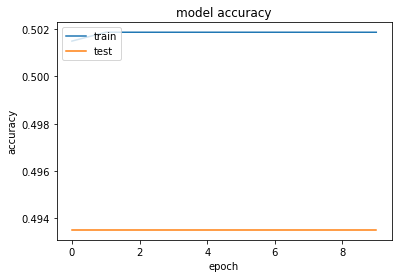

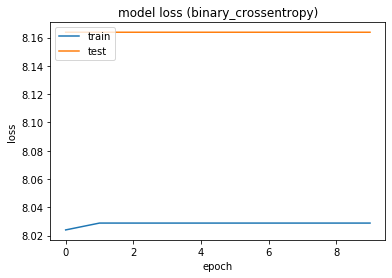

In [5]:
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (categorical_crossentropy)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()